# Introduction to mathematical morphology
This notebook will use skimage perform morphological operations. If anything is unclear, or you want to explore what functions are available yourselv, you can find the documentation [here](https://scikit-image.org/docs/dev/api/skimage.morphology.html).

The notebook mainly focuses on application of the morphological methods introduced in the lectures. Therefor it is highly recommended to first read the lecture slides, in order to understand the basics behind the concepts.

In [13]:
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage import data
from skimage import morphology
from ipywidgets import interact_manual, interact, widgets, interactive
from IPython.display import display

## Basic set operations
The language of morphology is set operations. The most basic ones can be explored here.

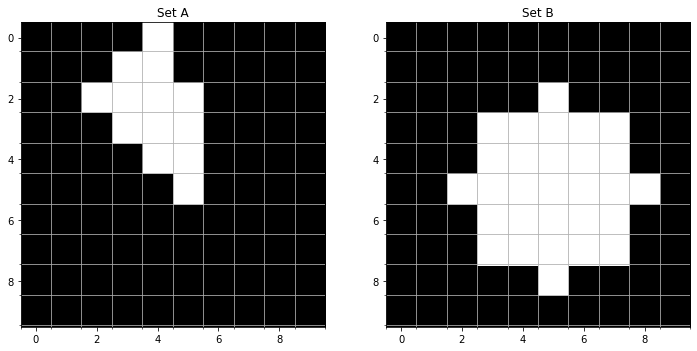

interactive(children=(Dropdown(description='operation', options=('union', 'intersection', 'Complement of A', '…

In [35]:
def plot_with_grid(image, cmap = "gray", offset = -0.05):
    ax = plt.gca()
    ax.set_xticks(np.arange(-.50, image.shape[1], 1), minor=True);
    ax.set_yticks(np.arange(-.50 + offset, image.shape[0], 1), minor=True);
    plt.grid(which="minor")
    plt.imshow(image, cmap = "gray")
    
def set_operations(a,b,operation):
    if(operation == "union"):
        c = a|b
    elif(operation == "intersection"):
        c = a&b
    elif(operation == "Complement of A"):
        c = ~ a
    elif(operation == "Complement of B"):
        c = ~ b
    elif(operation == "A - B"):
        c = a ^ a&b
    elif(operation == "B - A"):
        c = b ^ a&b
    plt.title(operation)
    plot_with_grid(c)
    plt.show()
    
a = np.zeros((10,10), dtype = bool)
a[:2, 4] = True
a[1,3] = True
for i in range(2,6):
    a[i, i:6] = True

b = np.array([[True if (x-5)**2 + (y-5)**2 < 10 else False for x in range(10)] for y in range(10)])

plt.figure(figsize = (12,6))
plt.subplot(121)
plt.title("Set A")
plot_with_grid(a)
plt.subplot(122)
plt.title("Set B")
plot_with_grid(b)
plt.show()


_ = interact_manual(set_operations, a = widgets.fixed(a), b = widgets.fixed(b),
                   operation = ["union", "intersection", "Complement of A", "Complement of B", "A - B", "B - A"])

### Reflect and translate
Two other set operations that will be important for mathematical morphology are the reflect and translate operations.

The reflection operation mirrors the structuring element across the middle pixel. The translation operation translates all pixels in the structuring element by $[x, y]$.


In [42]:
def reflect_translate(reflect, x, y):
    kernel = np.zeros((7,7,3))
    for i in range(3,7):
        kernel[i, i:7] = [255,255,255]
    if reflect:
        kernel = kernel[::-1, ::-1]
    
    kernel[3,3] *= 0.7
    image = np.zeros((15,15,3), dtype = np.uint8)
    
    image[4+y:11+y, 4+x:11+x] = kernel
    
    plt.figure(figsize = (8,8))
    plot_with_grid(image, offset = 0)
    plt.show()
    
_ = interact(reflect_translate, reflect = False, x = widgets.IntSlider(min = -4, max = 4, value = 0),
                                 y = widgets.IntSlider(min = -4, max = 4, value = 0))

interactive(children=(Checkbox(value=False, description='reflect'), IntSlider(value=0, description='x', max=4,…

## Hit and Fit
The basic operations in morphology rely on two key concepts: hit and fit. Basically two objects hit if they have any sections in common, and a structuring element fits in an object if it is a subset of the object. 

Everytime there is a fit there will also be a hit. The following demonstration will color the structuring element green if there is a fit, blue if there is a hit and red elsewise.

In [9]:
def construct_object():
    a = np.zeros((10,10), dtype = bool)
    a[:2, 4] = True
    a[1,3] = True
    for i in range(2,6):
        a[i, i:6] = True
    b = np.array([[True if (x-5)**2 + (y-5)**2 < 10 else False for x in range(10)] for y in range(10)])
    c = np.array([255*(b ^ a&b).astype(np.uint8) for _ in range(3)]).transpose(1,2,0)
    c = np.ascontiguousarray(c)
    return c
def hit_or_fit(se_type, x, y):
    se = kernels[se_type]
    image = construct_object()
    kh, kw = se.shape
    image_patch = image[y-kh//2:y+kh//2 +1, x - kw//2:x + kw//2 +1]
    
    #Fit
    if((se & image_patch[:,:,0]) ==se).all():
        plt.title("Fit and Hit!")
        image[y-kh//2:y+kh//2 +1, x - kw//2:x + kw//2 +1, :] = np.where(se.reshape(3,3,1), [0,255,0], image_patch)
    #Hit
    elif (se & image_patch[:,:,0]).any():
        plt.title("Hit!")
        image[y-kh//2:y+kh//2+1, x - kw//2:x + kw//2+1, :] = np.where(se.reshape(3,3,1), [0,0,255], image_patch)
    else:
        plt.title("No fit or hit!")
        image[y - kh//2:y+kh//2+1, x - kw//2:x + kw//2+1, :] = np.where(se.reshape(3,3,1), [255,0,0], image_patch)
    plot_with_grid(image, cmap = "rgb")
    plt.show()
    
kernels = {"cross" : np.array([[0,1,0], [1,1,1], [0,1,0]], dtype = bool),
           "L" : np.array([[1,0,0], [1,0,0], [1,1,1]], dtype = bool),
           "box" : np.ones((3,3), dtype = bool)}    


_ = interact(hit_or_fit, se_type = kernels.keys(), x = widgets.IntSlider(min = 1, max = 8),
                    y = widgets.IntSlider(min = 1, max = 8))
    

interactive(children=(Dropdown(description='se_type', options=('cross', 'L', 'box'), value='cross'), IntSlider…

## Mechanism - Erosion and Dilation
The following code-snippets demonstrate visually the mechanisms behind erosion and dilation. The kernel will be colored red normally, but will have its color changed to green whenever there is a fit or hit depending on which operation. You may observe the output in the right subfigure. Observe that whenever the kernel is colored green, marking a fit or hit, the output changes.

### Erosion
Binary erosion is defined by fits between the kernel and image objects.

In [23]:
image = np.zeros((10,10,3), dtype = np.uint8)
image[2:8, 3:7, : ] = 255

kernels = {"Cross": np.array([[0,1,0],[1,1,1],[0,1,0]], dtype = bool),
           "L" : np.array([[1,0,0], [1,0,0], [1,1,1]], dtype = bool),
           "box" : np.ones((3,3), dtype = bool)} 

def erosion(image, kernel_type):
    '''
    Buffers up all frames of the animation for performance.
    '''
    kernel = kernels[kernel_type]
    image_h, image_w, _ = image.shape
    output = np.zeros((image_h, image_w), dtype = np.uint8)
    pad_h = kernel.shape[0]//2
    pad_w = kernel.shape[1]//2

    image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0,0)), mode = "constant")
    displays = []
    outputs = []
    for y in range(1, image_h-1):
        for x in range(1, image_w-1):
            image_patch = image[y:y+kernel.shape[0], x:x + kernel.shape[1], 2]
            display = image.copy()
            
            #Fit logic
            if (((kernel & image_patch) == kernel).all()):
                output[y,x] = 215
                outputs.append(output.copy())
                output[y,x] = 255
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 1] = np.where(kernel, 255, image_patch)
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 0] = np.where(kernel, 0, image_patch)
            else:
                output[y,x] = 75
                outputs.append(output.copy())
                output[y,x] = 0
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 0] = np.where(kernel, 255, image_patch)
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 1] = np.where(kernel, 0, image_patch)
            display[y:y+kernel.shape[0], x:x + kernel.shape[1], 2] = np.where(kernel, 0, image_patch)
            display[y+pad_h,x+pad_w] = display[y+pad_h,x+pad_w]*0.5 if display[y+pad_h,x+pad_w].any() else [127, 127, 127]
            displays.append(display[pad_h:-pad_h, pad_w:-pad_w])
            
            
    return np.array(displays), np.array(outputs)
 
def interactive_display(kernel, displays, outputs, step):
    '''
    Displays the pre-buffered frames
    '''
    displays = displays[kernel]
    outputs = outputs[kernel]
    plt.figure(figsize = (12,6))
    plt.subplot(121)
    plt.title("Original image with kernel")
    plt.imshow(displays[step])
    
    ax = plt.gca()
    ax.set_xticks(np.arange(-.51, displays.shape[2], 1), minor=True);
    ax.set_yticks(np.arange(-.51, displays.shape[1], 1), minor=True);
    plt.grid(which="minor")
    
    plt.subplot(122)
    plt.title("Current output")
    plt.imshow(outputs[step], cmap = "gray", vmin = 0, vmax = 255)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.51, outputs.shape[2], 1), minor=True);
    ax.set_yticks(np.arange(-.51, outputs.shape[1], 1), minor=True);
    plt.grid(which="minor")
    plt.show()

    
displays = {}
outputs = {}
for kernel in kernels.keys():
    displays[kernel], outputs[kernel] = erosion(image, kernel)
_ = interact(interactive_display, kernel = kernels.keys(), displays = widgets.fixed(displays), outputs= widgets.fixed(outputs),\
                    step = widgets.IntSlider(min = 0, max = displays[list(kernels.keys())[0]].shape[0]-1, value = 0), continous_update=False)

interactive(children=(Dropdown(description='kernel', options=('Cross', 'L', 'box'), value='Cross'), IntSlider(…

### Dilation
Dilation is defined by hits between the reflected kernel and image-objects. If the kernel is symmetric around the center, it will be equal to its reflection.

The implementation of dilation is very similar to erosion. The loop and almost all logic is the same. The only two changes are that we now reflect the structuring element, and that we change the fit logic to hit logic. These two changes are commented in the code.

In [26]:
image = np.zeros((10,10,3), dtype = np.uint8)
image[2:8, 3:7, : ] = 255

kernels = {"Cross": np.array([[0,1,0],[1,1,1],[0,1,0]], dtype = bool),
           "L" : np.array([[1,0,0], [1,0,0], [1,1,1]], dtype = bool),
           "box" : np.ones((3,3), dtype = bool)} 

def dilation(image, kernel_type):
    '''
    Buffers up all frames of the animation for performance.
    '''
    kernel = kernels[kernel_type]
    #Flip the kernel
    kernel = kernel[::-1, :: -1]
    
    image_h, image_w, _ = image.shape
    output = np.zeros((image_h, image_w), dtype = np.uint8)
    pad_h = kernel.shape[0]//2
    pad_w = kernel.shape[1]//2

    image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0,0)), mode = "constant")
    displays = []
    outputs = []
    for y in range(1, image_h - 1):
        for x in range(1, image_w -1):
            image_patch = image[y:y+kernel.shape[0], x:x + kernel.shape[1], 2]
            display = image.copy()
            
            #Change fit logic to hit logic
            if ((kernel & image_patch).any()):
                output[y,x] = 215
                outputs.append(output.copy())
                output[y,x] = 255
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 1] = np.where(kernel, 255, image_patch)
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 0] = np.where(kernel, 0, image_patch)
            else:
                output[y,x] = 75
                outputs.append(output.copy())
                output[y,x] = 0
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 0] = np.where(kernel, 255, image_patch)
                display[y:y+kernel.shape[0], x:x + kernel.shape[1], 1] = np.where(kernel, 0, image_patch)
            display[y:y+kernel.shape[0], x:x + kernel.shape[1], 2] = np.where(kernel, 0, image_patch)
            display[y+pad_h,x+pad_w] = display[y+pad_h,x+pad_w]*0.5 if display[y+pad_h,x+pad_w].any() else [127, 127, 127]
            displays.append(display[pad_h:-pad_h, pad_w:-pad_w])
    return np.array(displays), np.array(outputs)

displays = {}
outputs = {}
for kernel in kernels.keys():
    displays[kernel], outputs[kernel] = dilation(image, kernel)
_ = interact(interactive_display, kernel = kernels.keys(), displays = widgets.fixed(displays), outputs= widgets.fixed(outputs),\
                    step = widgets.IntSlider(min = 0, max = displays[list(kernels.keys())[0]].shape[0]-1, value = 0), continous_update=False)

interactive(children=(Dropdown(description='kernel', options=('Cross', 'L', 'box'), value='Cross'), IntSlider(…

## Basic operations
There are two basic morphological operations: erosion and dilation. Erosion erodes away structures, leaving thinner objects, larger holes and in general reduces the size of objects. Dilation dilates structures leaving thicker lines, closed holes and larger objects. 

In addition there are two compound operations: opening and closing. To apply an opening you first erode the image, opening holes and removing thin segments, before dilating the result, recovering some of the original object size. Closings are the other way around. First you dilate the image, closing all holes, before eroding the result to recover the original object size.

A longer and perhaps a bit clearer introduction to the basic operations can be found [here](https://medium.com/@himnickson/morphological-operations-in-image-processing-cb8045b98fcc). 

The following snippet allows you to experiment with different structuring elements on a basic image with boxes and holes.

In [203]:

structuring_elements = {"disk" : morphology.disk,
                        "diamond" : morphology.diamond,
                        "star" : morphology.star,
                        "square" : morphology.square}

def make_image():
    image = np.zeros((100, 100), dtype = bool)
    
    for i in range(8):
        x, y, w, h = random.randint(0,99), random.randint(0,99), random.randint(10,20), random.randint(10,20)
        image[x:x+w, y:y+h] = True
        for j in range(random.randint(1,2)):
            x1, y1, w1, h1 = random.randint(x+3,x+w -7), random.randint(y+3,y+h-7),\
                            random.randint(2, 5), random.randint(2, 5)
            image[x1:x1+w1, y1:y1+h1] = False
    return image

def display_all_operations(se_type, se_size, image):

    structuring_element = structuring_elements[se_type](se_size)

    plt.figure(figsize = (10,12))

    plt.subplot(321)
    plt.title("Original image")
    plt.imshow(image,cmap = "gray")

    plt.subplot(322)
    plt.title("Structuring element")
    plt.imshow(structuring_element, cmap = "gray")


    plt.subplot(323)
    erosion = morphology.binary_erosion(image, structuring_element)
    plt.title("Erosion")
    plt.imshow(erosion, cmap = "gray")

    plt.subplot(324)
    dilation = morphology.binary_dilation(image, structuring_element)
    plt.title("Dilation")
    plt.imshow(dilation, cmap = "gray")

    plt.subplot(325)
    opened = morphology.binary_opening(image, structuring_element)
    plt.title("Opening")
    plt.imshow(opened, cmap = "gray")

    plt.subplot(326)
    closed = morphology.binary_closing(image,structuring_element)
    plt.title("Closing")
    plt.imshow(closed, cmap = "gray")
    plt.show()
    
    
_ = interact_manual(display_all_operations, se_type = structuring_elements.keys(),\
                    se_size = widgets.IntSlider(min = 1, max = 15, value = 3),\
                   image = widgets.fixed(make_image()))

interactive(children=(Dropdown(description='se_type', options=('disk', 'diamond', 'star', 'square'), value='di…

One possible use-case for morphology is to increase the quality of the segmentation result when extracting text from images. The result of the segmentation step will often have imperfections that can be improved with morphology.

See if you can improve the following image:

In [120]:
#Get a broken image directly
image = plt.imread("images/text-broken.tif")[:,:,0]


_ = interact_manual(display_all_operations, se_type = structuring_elements.keys(),\
                    se_size = widgets.IntSlider(min = 1, max = 15, value = 3),\
                   image = widgets.fixed(image))

interactive(children=(Dropdown(description='se_type', options=('disk', 'diamond', 'star', 'square'), value='di…

## Boundary extraction
Dilation increases the size of structures, and erosion decreases the size of structures. If we want to extract the boundary of objects we can apply either dilation or erosion on the image, and then perform a pixelwise exclusive or operation with the original image.

If we apply erosion xor'ed with the original image we get the inner boundary. On the other hand, if we perform dilation xor'ed with the original image we get the outer boundary. In binary images xor is the same as taking the difference. If we work with gray-scale images instead, we will have better luck with straigth up taking the difference.

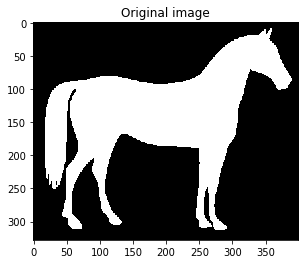

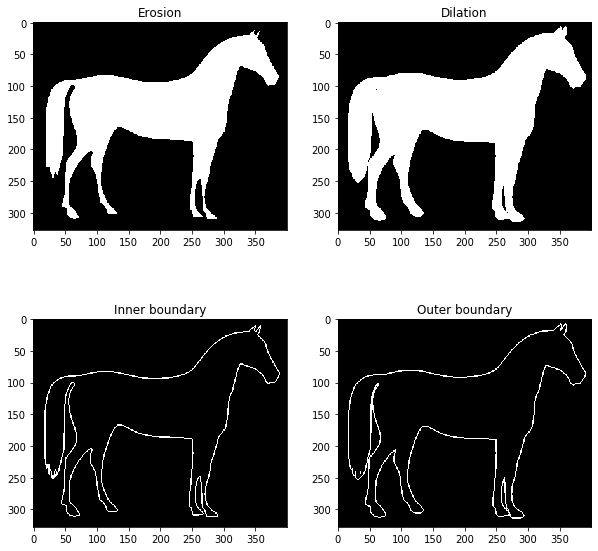

In [81]:
image = ~data.horse()

se = morphology.disk(2)
eroded = morphology.binary_erosion(image, se)
dilated = morphology.binary_dilation(image, se)

plt.title("Original image")
plt.imshow(image, cmap = "gray")
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(eroded, cmap = "gray")
plt.title("Erosion")

plt.subplot(222)
plt.imshow(dilated, cmap = "gray")
plt.title("Dilation")

plt.subplot(223)
plt.imshow(eroded^image, cmap = "gray")
plt.title("Inner boundary")

plt.subplot(224)
plt.imshow(dilated^image, cmap = "gray")
plt.title("Outer boundary")
plt.show()

Using grayscale morphology instead of binary morphology, this can be used to extract edges of objects. The following code snippet applies the exact same process as above, only on a gray-scale image instead of a binary image.

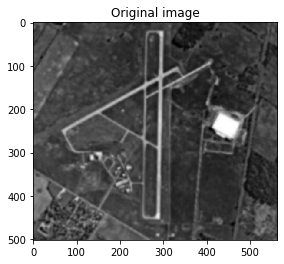

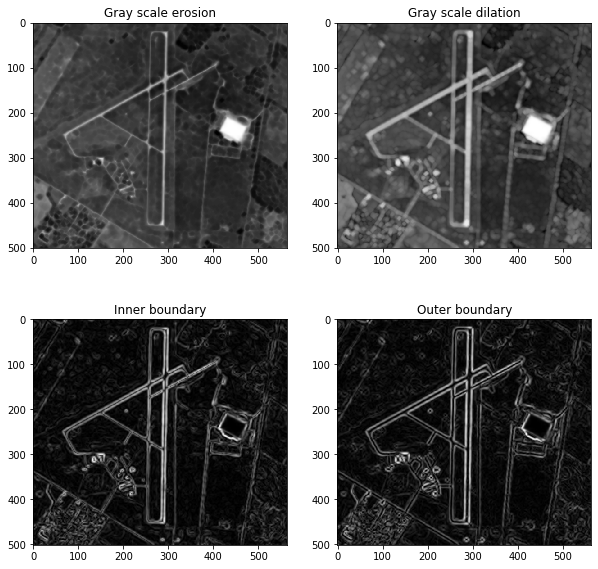

In [3]:
from skimage import filters
image = plt.imread("images/airport.tif")

#Filter the image for noise first
image = filters.gaussian(image, 2)

se = morphology.disk(2)
eroded = morphology.erosion(image, se)
dilated = morphology.dilation(image, se)

plt.title("Original image")
plt.imshow(image, cmap = "gray")
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(eroded, cmap = "gray")
plt.title("Gray scale erosion")

plt.subplot(222)
plt.imshow(dilated, cmap = "gray")
plt.title("Gray scale dilation")

plt.subplot(223)
plt.imshow(image-eroded, cmap = "gray")
plt.title("Inner boundary")

plt.subplot(224)
plt.imshow(dilated-image, cmap = "gray")
plt.title("Outer boundary")
plt.show()

## Top hat transform
The top-hat transform is the difference between the input image and the opening of the image.

It has a few different applications. It can be used to enhance contrast in a grayscale image with non uniform illumination. It can also be used to isolate small bright objects in an image.

In [4]:


#Filter the image for noise first
def top_hat_transform(image_name, se_size):
    image = plt.imread(f"images/{image_name}.tif")
    image = filters.gaussian(image, 2)

    se = morphology.disk(se_size)
    opening = morphology.opening(image, se)
    plt.figure(figsize  = (15, 5))
    plt.subplot(1,3,1)
    plt.title("Original image")
    plt.imshow(image, cmap = "gray")

    plt.subplot(1,3,2)
    plt.title("Opening")
    plt.imshow(opening, cmap = "gray", vmin = 0, vmax = 1, interpolation = "none")

    plt.subplot(1,3,3)
    plt.title("Top hat transform")
    plt.imshow(image - opening, cmap = "gray")
    plt.show()
    
    
_ = interact_manual(top_hat_transform, image_name = ["rice", "airport"],\
                    se_size = widgets.IntSlider(min = 1, max = 70, value = 5))

interactive(children=(Dropdown(description='image_name', options=('rice', 'airport'), value='rice'), IntSlider…